In [1]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib as plt
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from nltk.corpus import stopwords
from mejores_modelos.funciones_aux import imprimir_resultados, guardar_resultado_en_csv
from tensorboard.plugins.hparams import api as hp

2024-06-25 11:12:13.011958: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 11:12:13.292711: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 11:12:13.997999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 11:12:15.568285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Aqui utilizamos el archivo train_limpio.csv que es el train.csv pero filtrado sacando reseñas que no estaban en español

In [2]:
RUTA_TRAIN, RUTA_TEST = "train_limpio.csv", "test.csv"

In [3]:
df_train = pd.read_csv(RUTA_TRAIN)
df_test = pd.read_csv(RUTA_TEST)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        48182 non-null  int64 
 1   ID                48182 non-null  int64 
 2   review_es         48182 non-null  object
 3   sentimiento       48182 non-null  object
 4   idioma_detectado  48182 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


Aqui ya observamos que el dataset no contiene nulos

<Axes: xlabel='sentimiento', ylabel='count'>

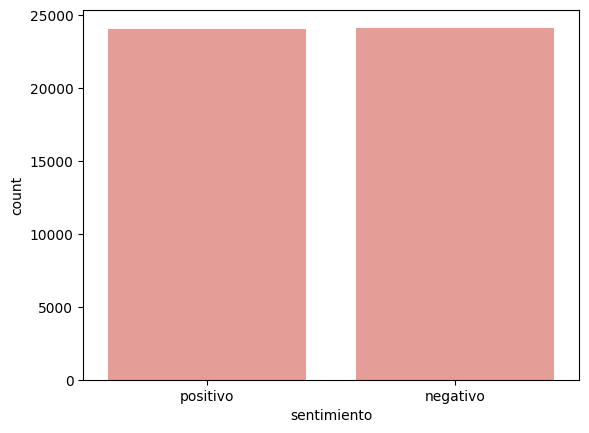

In [5]:
sns.countplot(x=df_train["sentimiento"], color="#F1948A")

In [6]:
df_train["sentimiento"].value_counts()

sentimiento
negativo    24133
positivo    24049
Name: count, dtype: int64

In [7]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [8]:
df_train["review_es"], df_test["review_es"] = df_train["review_es"].str.lower(), df_test["review_es"].str.lower()

In [9]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.3, random_state=33)

In [10]:
x_train, y_train, x_test_, y_test_ = df_train_train["review_es"], df_train_train["sentimiento"], df_train_test["review_es"], df_train_test["sentimiento"]

In [11]:
x_test = df_test["review_es"]

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test_)

## Bernoulli Naive Bayes

In [14]:
def busqueda_hiperparametros_nb(modelo, x_vectorizado):
  param_grid = {
    "alpha": [0.6, 0.65, 0.7, 0.8],
    "fit_prior": [False, True],
    "class_prior": [[0.2, 0.6], [0.1, 0.5], [0.2, 0.7]]
  }
  
  grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=10, scoring="f1_macro")
  
  grid_search.fit(x_vectorizado, y_train)

  return grid_search

In [15]:
nb_classifier = BernoulliNB()
gs = busqueda_hiperparametros_nb(nb_classifier, x_train_vec)

In [16]:
print(gs.best_params_)

{'alpha': 0.8, 'class_prior': [0.2, 0.6], 'fit_prior': False}


In [17]:
best_nb = BernoulliNB(alpha=gs.best_params_["alpha"], fit_prior=gs.best_params_["fit_prior"])

gs.fit(x_train_vec, y_train)
y_pred_nb = gs.predict(x_test_vec)

F1: 0.8555018561322406
Precision: 0.8682115439294854
Recall: 0.8431589120530167
Accuracy: 0.8572812175717744


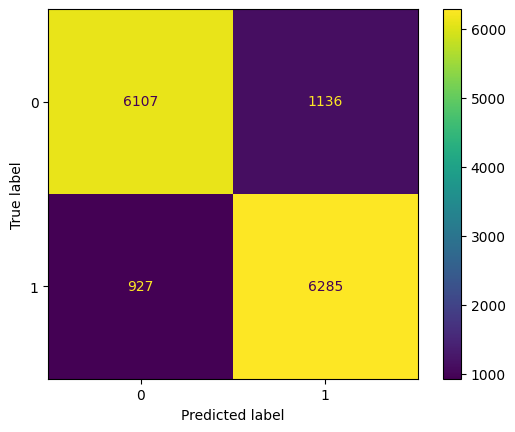

In [18]:
imprimir_resultados(y_test_, y_pred_nb)

In [19]:
y_pred_nb_ = gs.predict(vectorizer.transform(x_test))

In [20]:
RUTA_NB = "nb_notebook_entrega.csv"
guardar_resultado_en_csv(y_pred_nb_, df_test, RUTA_NB)

In [21]:
guardar_resultado_en_csv(y_pred_nb_, df_test, RUTA_NB)

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [23]:
def func_classif(param_distributions, cv, scoring, estimator, n_iter):
  randomcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions = param_distributions,
                                scoring=scoring,
                                cv=cv,
                                n_jobs = -1,
                                n_iter=n_iter,
                                random_state=33)

  randomcv.fit(x_train_vec, y_train)

  return randomcv

In [24]:
n_iter = 5

param_distributions = { 
    "criterion" : ["gini", "entropy", "log_loss"],
    "min_samples_leaf" : [1, 5, 10],
    "min_samples_split" : [2, 4, 10, 12, 16],
    "n_estimators": [10, 20, 50, 70, 100],
    "max_depth": range(15, 50) }


cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = RandomForestClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [25]:
best_rf = randomcv.best_estimator_

In [26]:
best_params_rf = randomcv.best_params_

In [27]:
best_rf = RandomForestClassifier(
            criterion=best_params_rf["criterion"],
            min_samples_leaf=best_params_rf["min_samples_leaf"],
            min_samples_split=best_params_rf["min_samples_split"],
            n_estimators=best_params_rf["n_estimators"],
            max_depth=best_params_rf["max_depth"])

In [28]:
best_rf.fit(x_train_vec, y_train)

y_pred_rf = best_rf.predict(x_test_vec)

F1: 0.8375209380234506
Precision: 0.8468595624558928
Recall: 0.8283860278889963
Accuracy: 0.8389484607402283


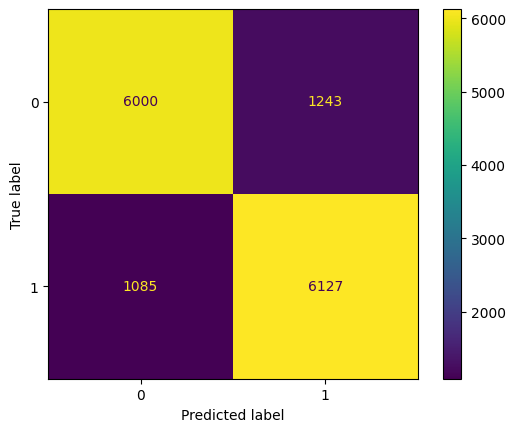

In [29]:
imprimir_resultados(y_test_, y_pred_rf)

In [30]:
y_pred_rf_ = best_rf.predict(vectorizer.transform(x_test))

In [31]:
RUTA_RF = "rf_notebook_entrega.csv"
guardar_resultado_en_csv(y_pred_rf_, df_test, RUTA_RF)

In [32]:
guardar_resultado_en_csv(y_pred_rf_, df_test, RUTA_RF)

## XGBoost

In [33]:
from xgboost import XGBClassifier

In [34]:
n_iter = 5

param_distributions = { 
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4],
    "max_depth": [3, 4, 5, 7],
    "n_estimators": [100, 200, 300] 
    }

cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = XGBClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [35]:
best_params_xgboost = randomcv.best_params_

In [36]:
best_xgboost = XGBClassifier(learning_rate=best_params_xgboost["learning_rate"],
                        n_estimators=best_params_xgboost["n_estimators"],
                        max_depth=best_params_xgboost["max_depth"])

In [37]:
best_xgboost.fit(x_train_vec, y_train)

y_pred_xgboost = best_xgboost.predict(x_test_vec)

F1: 0.860176002234949
Precision: 0.8703886925795054
Recall: 0.8502001932900731
Accuracy: 0.8615012106537531


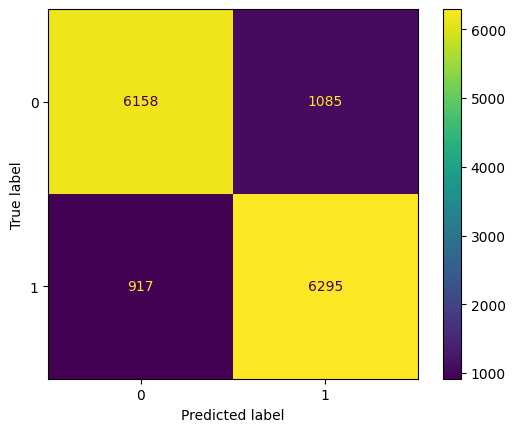

In [38]:
imprimir_resultados(y_test_, y_pred_xgboost)

In [39]:
y_pred_xgboost_ = best_xgboost.predict(vectorizer.transform(x_test))

In [40]:
RUTA_XGBOOST = "xgboost_notebook_entrega.csv"

In [41]:
guardar_resultado_en_csv(y_pred_xgboost_, df_test, RUTA_XGBOOST)

## Red neuronal

In [42]:
max_words = 5000
max_len = 100

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.text import Tokenizer

In [44]:
total_reviews = df_train["review_es"].astype(str)
total_labels = df_train["sentimiento"].values

In [45]:
tokenizer_obj = Tokenizer(num_words = max_words)
tokenizer_obj.fit_on_texts(total_reviews)

In [46]:
X_data_tokens = tokenizer_obj.texts_to_sequences(total_reviews)

In [47]:
X_data_count = tokenizer_obj.sequences_to_matrix(X_data_tokens, mode = "count")

In [48]:
Y_data = df_train.sentimiento

In [49]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_data_count, Y_data, test_size = 0.3, random_state = 123)

Aqui por razones de memoria decidimos dejar la busqueda de la red en el notebook que se encuentra en `mejores_modelos/mejorRed` porque hemos busacado hiperparámetros en esta notebook pero nos quedamos sin memoria, y quitando eso, si bien la busqueda de hiperparametros normal nos ha dado un puntapie inicial, finalmente terminamos jugando con los valores a mano, llegando a lo obtenido en el archivo que ahora importaremos `mejor_modelo/modeloRed.keras`

In [50]:
import keras

In [51]:
mejor_red = keras.models.load_model("mejores_modelos/modeloRed.keras")

mejor_red.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 650)            │     3,250,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 650)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 250)            │       162,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 35)             │         8,785 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,266,665 (39.16 MB)

 Trainable params: 3,422,221 (13.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,844,444 (26.11 MB)

In [52]:
X_train_tokens = tokenizer_obj.texts_to_sequences(df_test["review_es"])
X_train_count = tokenizer_obj.sequences_to_matrix(X_train_tokens, mode = "count")
y_pred_red_ = mejor_red.predict(X_test_count)
y_pred_red_ = np.round(y_pred_red_)

  1/452 ━━━━━━━━━━━━━━━━━━━━ 1:04 144ms/step

2024-06-25 11:16:37.909639: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 289100000 exceeds 10% of free system memory.


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Aunque ya las hemos mostrado

F1: 0.8708800780433419
Precision: 0.8793976920911906
Recall: 0.8625258799171842
Accuracy: 0.8718090626080941


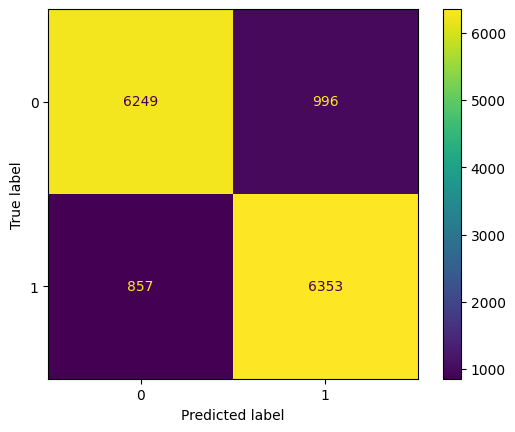

In [53]:
imprimir_resultados(y_test_count, y_pred_red_)

In [54]:
RUTA_RED = "red_notebook_entrega.csv"

In [55]:
X_test_tokens = tokenizer_obj.texts_to_sequences(df_test["review_es"])
X_test_count = tokenizer_obj.sequences_to_matrix(X_test_tokens, mode = "count")
y_pred = mejor_red.predict(X_test_count)
y_pred = np.round(y_pred)

 90/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2024-06-25 11:16:42.111282: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 171980000 exceeds 10% of free system memory.


269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [56]:
y_pred = np.where(y_pred == 0, "negativo", "positivo")
df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": y_pred.flatten()})

df_predicciones.to_csv(RUTA_RED, header=["ID", "sentimiento"], index=False)

## Ensamble

In [57]:
from collections import Counter

In [58]:
def ensamble_votacion(array1, array2, array3):
    combined = np.vstack((array1, array2, array3)).T
    
    resultado = np.apply_along_axis(lambda row: Counter(row).most_common(1)[0][0], axis=1, arr=combined)
    
    return resultado

F1: 0.8658741258741258
Precision: 0.8772849652826981
Recall: 0.8547563164434626
Accuracy: 0.8673123486682809


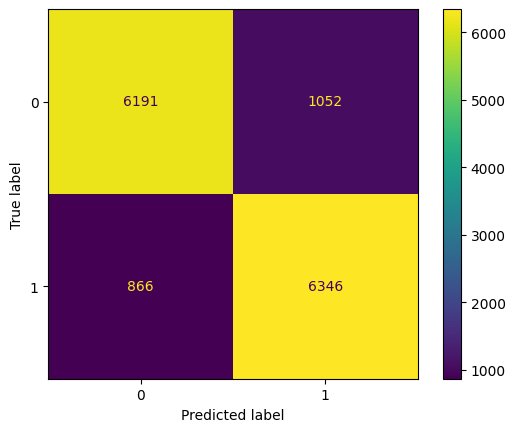

In [59]:
imprimir_resultados(y_test_, ensamble_votacion(y_pred_nb, y_pred_rf, y_pred_xgboost))

In [60]:
guardar_resultado_en_csv(ensamble_votacion(y_pred_nb_, y_pred_rf_, y_pred_xgboost_), df_test, "ensamble.csv")